# S0: Data Source

In [ ]:
#https://www.kaggle.com/datasets/adilshamim8/social-media-addiction-vs-relationships?resource=download

# S1. Import and Data Loading

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/addiction.csv"

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# S2. Initial Cleaning

In [ ]:
#too many unique vals, pain to train with this col
df = df.drop(columns=['Country'])
df = df.drop(columns=['Age'])

#only care about most used social medias
platforms = ['Instagram', 'Twitter', 'TikTok', 'YouTube', 'Facebook']
df = df[df['Most_Used_Platform'].isin(platforms)]


# S3. Encoding

##Isolating Object Cols

In [ ]:
dtypes = dict(df.dtypes)

obj_cols = []

for col, dtype in dtypes.items():
    if dtype=='object':
      obj_cols.append(col)
      # print(col, dtype)

df_obj = df[obj_cols]
df_obj

for col in df_obj.columns:
  print(col, df[col].nunique())



Gender 2
Academic_Level 3
Most_Used_Platform 5
Affects_Academic_Performance 2
Relationship_Status 3


##One-Hot, Ordinal, Binary Encodings for Objects

In [ ]:
#binary for this
df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})

#ordinal meaning here
edu_order = ['High School', 'Undergraduate', 'Graduate']
df['Academic_Level'] = pd.Categorical(df['Academic_Level'], categories=edu_order, ordered=True).codes

#one hot for all rest
df = pd.get_dummies(df, columns=['Gender', 'Most_Used_Platform', 'Relationship_Status'], drop_first=True)
df.columns = df.columns.str.replace(' ', '_')



##Dropping the Object Rows After Encoding

In [ ]:
#now dont need the obj cols as the model cant read them anyway, are present in df_obj

df = df.drop(columns=[col for col in obj_cols if col in df.columns])



##Making Everything Numerical

In [ ]:
df = df.apply(pd.to_numeric)

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

print(df.dtypes)

Student_ID                               int64
Avg_Daily_Usage_Hours                  float64
Sleep_Hours_Per_Night                  float64
Mental_Health_Score                      int64
Conflicts_Over_Social_Media              int64
Addicted_Score                           int64
Gender_Male                              int64
Most_Used_Platform_Instagram             int64
Most_Used_Platform_TikTok                int64
Most_Used_Platform_Twitter               int64
Most_Used_Platform_YouTube               int64
Relationship_Status_In_Relationship      int64
Relationship_Status_Single               int64
dtype: object


# S4 .Training

## Split Into Train, Test

In [ ]:
from sklearn.model_selection import train_test_split


x = df.drop(columns=['Addicted_Score'])
y = df['Addicted_Score']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(452, 12)
(114, 12)
(452,)
(114,)


##Normalize Values

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#scaler use is for numerical data with diff ranges, like sleep hours [0-10] and academic level [0-2], there is imbalance as it doesnt rly know how to interpret
#the numbers differently given the context, so it scales everything such that mean=0, sd=1, still captures the same patterns as original data but
#"translated" for the machine to understand

## Model Architecture and Compilation

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # No activation for regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#S5: Optimization

##History and Evaluation with MAE

In [ ]:
history = model.fit(x_train_scaled, y_train, epochs=100, batch_size=16, validation_split=0.2)

loss, mae = model.evaluate(x_test_scaled, y_test)
print("Test MAE:", mae)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - loss: 49.1727 - mae: 6.8677 - val_loss: 41.7455 - val_mae: 6.3066
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.6233 - mae: 6.2824 - val_loss: 34.9735 - val_mae: 5.7505
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.1411 - mae: 5.5869 - val_loss: 27.1074 - val_mae: 5.0279
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.8063 - mae: 4.8966 - val_loss: 17.6351 - val_mae: 4.0011
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.3691 - mae: 3.7295 - val_loss: 8.6725 - val_mae: 2.6621
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9752 - mae: 2.4719 - val_loss: 3.4683 - val_mae: 1.4997
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9363 - mae: 1.3851 - val_loss: 2.3906 - val_mae: 1.2674
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4775 - mae: 1.3169 - val_loss: 1.9395 - val_mae: 1.1384
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

#S6: Predictions

In [ ]:
y_pred = model.predict(x_test_scaled)
y_pred_int = [int(round(score[0])) for score in y_pred]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


#S7: Plotting Results

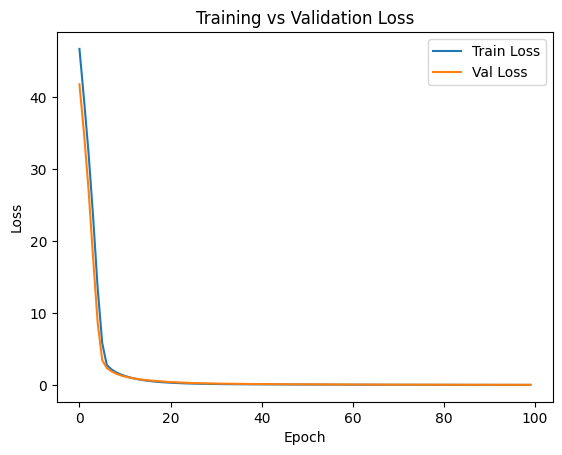

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

# S8. Interactive Game

##Info Printing Function

In [ ]:
def print_info(row):
    print(f"{'ID:':<30}{int(row['Student_ID'])}")
    print(f"{'Mental Health Score:':<30}{int(row['Mental_Health_Score'])}")
    print(f"{'Conflicts Over Social Media:':<30}{int(row['Conflicts_Over_Social_Media'])}")
    print(f"{'Avg Daily Usage (hours):':<30}{float(row['Avg_Daily_Usage_Hours']):.1f}")
    print(f"{'Sleep Hours Per Night:':<30}{float(row['Sleep_Hours_Per_Night']):.1f}")

    gender = "Male" if row["Gender_Male"] == 1 else "Female"
    print(f"{'Gender:':<30}{gender}")

    if row["Most_Used_Platform_Instagram"] == 1:
        platform = "Instagram"
    elif row["Most_Used_Platform_TikTok"] == 1:
        platform = "TikTok"
    elif row["Most_Used_Platform_Twitter"] == 1:
        platform = "Twitter"
    else:
        platform = "YouTube"
    print(f"{'Most Used:':<30}{platform}")

    if row["Relationship_Status_In_Relationship"] == 1:
        status = "In Relationship"
    else:
        status = "Single"
    print(f"{'Relationship Status:':<30}{status}")


## Game Implementation

In [ ]:
import random
import numpy as np

print()
print("Guess the Student's Social Media Addiction Level (Integer, 0-10) from the Stats")
print("Type 'q' to Quit\n")
print()

while True:
    idx = random.randint(0, len(x_test_scaled) - 1) #id for getting stats in testing data
    row = x_test.iloc[idx]  #original values (before scaling) for display
    scaled_input = np.array([x_test_scaled[idx]])  # scaled input for model

    actual_score = int(y_test.iloc[idx])
    predicted_score = int(model.predict(scaled_input)[0][0])

    print()
    print("User Stats:")
    print()
    print_info(row)
    print()

    guess = input("Guess: ").strip()

    if guess.lower() == 'q':
        print("Thanks for playing!")
        break

    try:
        guess = int(guess)
    except:
        print("Enter an Integer.")
        continue

    print()
    print(f"Your Guess: {guess}")
    print(f"Model's Prediction (Rounded): {int(round(predicted_score, 0))}")
    print(f"Actual Addicted Score: {actual_score}")
    print(f"Your Error: {abs(guess - actual_score)}")
    print(f"Model's Error: {abs(predicted_score - actual_score)}")
    print()
    print('-' * 50)
    print()



Guess the Student's Social Media Addiction Level (Integer, 0-10) from the Stats
Type 'q' to Quit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

User Stats:

ID:                           476
Mental Health Score:          6
Conflicts Over Social Media:  3
Avg Daily Usage (hours):      4.0
Sleep Hours Per Night:        8.2
Gender:                       Male
Most Used:                    TikTok
Relationship Status:          Single


Your Guess: 5
Model's Prediction (Rounded): 6
Actual Addicted Score: 7
Your Error: 2
Model's Error: 1

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

User Stats:

ID:                           343
Mental Health Score:          7
Conflicts Over Social Media:  3
Avg Daily Usage (hours):      4.7
Sleep Hours Per Night:        7.2
Gender:                       Female
Most Used:                    TikTok
Relationship Status:          Single


Your Guess: 6
Model's Prediction (Rounded): 6
Actual Addicted Score: 6
Your Error: 0


KeyboardInterrupt: Interrupted by user